In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper', 'ULTIMA COSA', 'PG')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [3]:
#Fix params
#L_bar = 0.90
beta = 1

num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters

confidence_level = 0.683 #1 sigma contour
#confidence_level = 0.954 #2 sigma contour
#confidence_level = 0.997 #3 sigma contour


In [4]:
from scipy.stats import chi2

def chi2_threshold(N, p, confidence):
    """
    Compute the chi-square threshold for model rejection based on a given confidence level.
    
    Parameters:
    N (int): Number of data points
    p (int): Number of parameters
    confidence (float): Confidence level (e.g., 0.95 for 95%)
    
    Returns:
    float: Reduced chi-square threshold
    """
    nu = N - p  # Degrees of freedom
    chi2_crit = chi2.ppf(confidence, df=nu)  # Critical chi-square value
    return chi2_crit / nu  # Convert to reduced chi-square

# Example usage
N = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])
p = 3
confidence_level = 0.683  # 68.3% confidence threshold

chi2_th = chi2_threshold(N, p, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {chi2_th:.5f}")
print(1+np.sqrt(2/(N-p)))


Reduced chi-square threshold for 68.30000000000001% confidence: 1.01610
1.0344622758397788


# PG model analysis

In [ ]:
#PG MODEL
#r_min = 1
#s_min = 2

model = 'PG'
#H0_values = np.linspace(60,80,20)[::-1] 
#L_bar_values = np.logspace(-1,1,20)
#Mabs_values = np.linspace(-21,-18.5,20)

H0_values = np.linspace(60,80,50)[::-1] 
L_bar_values = np.logspace(-1,1,50)
Mabs_values = np.linspace(-21,-18.5,50)
print(H0_values, L_bar_values, Mabs_values)

#r = 1; s = 2 
r = 1; s = 3 
#r = 1; s = 4 

matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_chi2_BETA_r={1}_s={2}_{0}.npy'.format(model, r, s)))
matrix_gila_aou = np.load(os.path.join(path_data, 'matrix_aou_BETA_r={1}_s={2}_{0}.npy'.format(model, r, s)))


[80.         78.94736842 77.89473684 76.84210526 75.78947368 74.73684211
 73.68421053 72.63157895 71.57894737 70.52631579 69.47368421 68.42105263
 67.36842105 66.31578947 65.26315789 64.21052632 63.15789474 62.10526316
 61.05263158 60.        ] [ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183
  0.42813324  0.54555948  0.6951928   0.88586679  1.12883789  1.43844989
  1.83298071  2.33572147  2.97635144  3.79269019  4.83293024  6.15848211
  7.8475997  10.        ] [-21.         -20.86842105 -20.73684211 -20.60526316 -20.47368421
 -20.34210526 -20.21052632 -20.07894737 -19.94736842 -19.81578947
 -19.68421053 -19.55263158 -19.42105263 -19.28947368 -19.15789474
 -19.02631579 -18.89473684 -18.76315789 -18.63157895 -18.5       ]


### Important questions

In [6]:
#aou_threshold = 13.2
aou_threshold = 12.7
chi2_th = chi2_threshold(N, p, confidence_level)
print('Aou threhold: {}'.format(aou_threshold))
print('chi2 threhold: {}'.format(chi2_th))

masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)

print('Has integration issues?: {}'.format(np.all(np.isnan(matrix_gila_chi2)))) #should be False
print('Has issues when Aou cut-off is applied?: {}'.format(np.all(np.isnan(masked_data_with_aou))))#should be False
print('chi2_min<=chi2_threshold?: {}'.format(np.nanmin(masked_data_with_aou)/dof<=chi2_th))#should be True


Aou threhold: 12.7
chi2 threhold: 1.0160978536321694
Has integration issues?: False
Has issues when Aou cut-off is applied?: False
chi2_min<=chi2_threshold?: True


In [7]:
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(masked_data_with_aou)/dof))

#Double check
where_global_min = np.where(masked_data_with_aou==np.nanmin(masked_data_with_aou))
masked_data_with_aou[where_global_min]/dof

Minimum of the reduced $\chi^2$:0.8896283228868261


array([0.88962832])

In [8]:
masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)
masked_data_with_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, matrix_gila_chi2, np.nan)
masked_data_with_aou_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, masked_data_with_aou, np.nan)

print(masked_data_with_aou)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

[[[290865.30327398 254177.36336413 219978.68702671 ...   5710.17065663
    11339.71147804  19458.51587187]
  [269793.59501698 234494.67469265 201685.01794075 ...   8251.79535344
    15270.35576037  24778.17973972]
  [261251.06999659 226541.99253482 194322.17864547 ...   9736.59899649
    17345.00226597  27442.66910788]
  ...
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]]

 [[283270.72137289 247083.24661372 213385.03542698 ...   6623.4963171
    12753.50228919  21372.77183371]
  [262221.23744243 227440.66313797 195149.35240594 ...   9491.32011665
    17028.22654344  27054.39654267]
  [253649.8166201  219469.97604464 187779.3990416  ...  11132.37268729
    19270.01284308  29896.9165713 ]
  ...
  [            nan      

# 3D Monte Carlo sampling

[[[2.30929544e-45 4.79973998e-40 4.34659615e-35 ... 4.95823614e-04
   7.57447753e-05 5.04163644e-06]
  [2.61650149e-42 3.42079914e-37 1.94862168e-32 ... 2.12290757e-04
   2.03997543e-05 8.54106752e-07]
  [4.52812476e-41 4.86216981e-36 2.27475814e-31 ... 1.29334988e-04
   1.02073975e-05 3.51000227e-07]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.91257527e-44 5.12242235e-39 3.92524689e-34 ... 3.65548579e-04
   4.72531308e-05 2.66139567e-06]
  [3.27564884e-41 3.60223627e-36 1.72599852e-31 ... 1.40367966e-04
   1.13456695e-05 3.99563322e-07]
  [5.72378144e-40 5.15091603e-35 2.01966466e-30 ... 8.11718472e-05
   5.36900886e-06 1.54730590e-07]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000

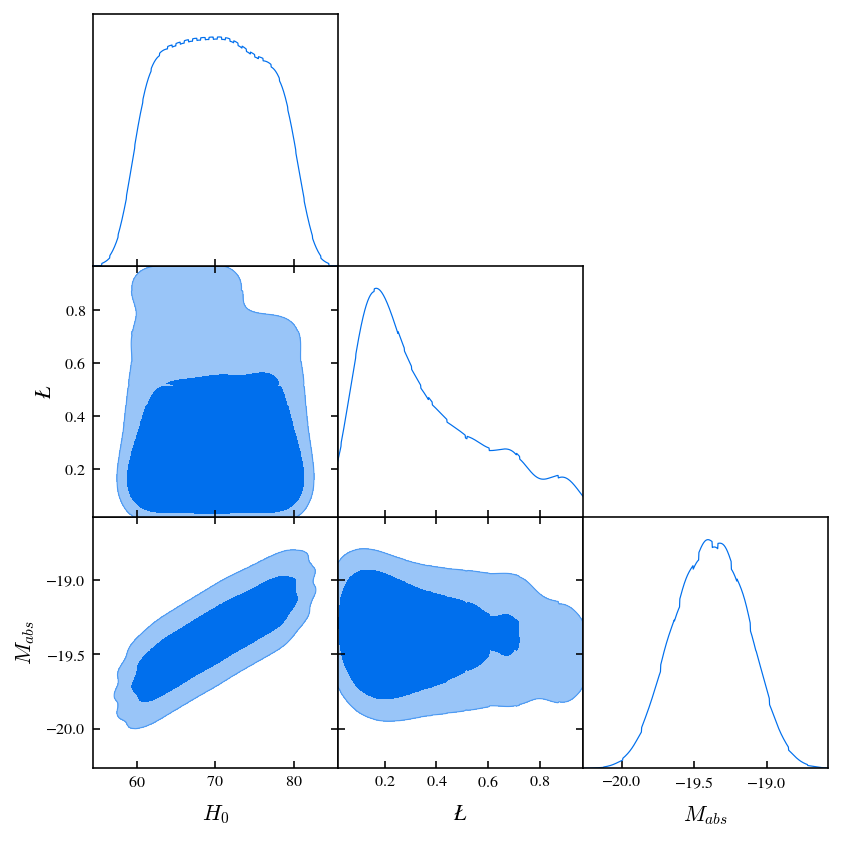

In [9]:
import getdist
import getdist.plots as gdplt
%matplotlib inline

x_vals = H0_values 
y_vals = L_bar_values 
z_vals = Mabs_values
#matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_gila_chi2.npy'))

#aux = matrix_gila_chi2.copy()/np.nanmin(matrix_gila_chi2)
#aux[np.isnan(matrix_gila_chi2)]=np.inf

aux = masked_data_with_aou.copy()/np.nanmin(masked_data_with_aou)
aux[np.isnan(masked_data_with_aou)]=np.inf

p3d = np.exp(-aux/2)

# Normalize the distribution
p3d /= np.sum(p3d)
print(p3d)
print(p3d.shape)
# Convert 3D posterior into samples
flattened_probs = p3d.flatten()
grid_points = np.array(np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')).reshape(3, -1).T

# Sample points from the distribution
num_samples = int(1e5)  # Number of samples you want
sample_indices = np.random.choice(len(flattened_probs), size=num_samples, p=flattened_probs)
samples = grid_points[sample_indices]

samples_1 = samples.copy()



# Convert to GetDist format
gd_samples = getdist.mcsamples.MCSamples(samples=samples, names=['x', 'y', 'z'],
                                         labels=[r'H_0', r'\L', r'M_{abs}'],
                                         settings={'mult_bias_correction_order':0,
                                                   'smooth_scale_2D':0.3,
                                                   'smooth_scale_1D':0.3}
                                         )

# Plot using GetDist
g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_samples], filled=True)
g.export(path_data+'triangle_gila_plot_{0}_r={1}_s={2}.pdf'.format(model, r, s))
plt.show()

69.88275789473684
0.3554548953420935
-19.385026315789474


(array([  147.,  1125.,  4700., 27979., 20239., 19786., 23165.,  2422.,
          391.,    46.]),
 array([-20.21052632, -20.03947368, -19.86842105, -19.69736842,
        -19.52631579, -19.35526316, -19.18421053, -19.01315789,
        -18.84210526, -18.67105263, -18.5       ]),
 <a list of 10 Patch objects>)

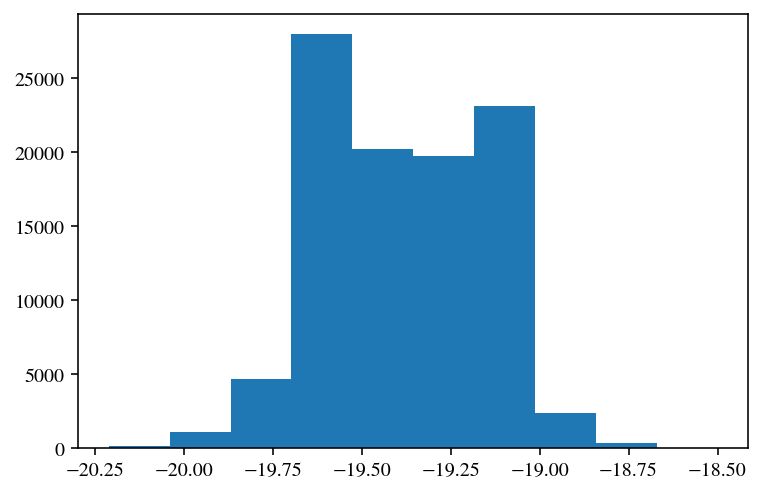

In [10]:
print(np.mean(samples[:,0]))
print(np.mean(samples[:,1]))
print(np.mean(samples[:,2]))
plt.hist(samples[:,2])

## 2D proyection

In [11]:
print(r'The global minima corresponds to M abs={0}'.format(Mabs_values[where_global_min[2][0]]))
matrix_gila_chi2_2d = matrix_gila_chi2[:,:,where_global_min[2][0]]/dof
masked_data_with_aou_2d = masked_data_with_aou[:,:,where_global_min[2][0]]/dof
masked_data_with_1_sigma_2d = masked_data_with_1_sigma[:,:,where_global_min[2][0]]/dof
masked_data_with_aou_1_sigma_2d = masked_data_with_aou_1_sigma[:,:,where_global_min[2][0]]/dof

The global minima corresponds to M abs=-19.289473684210527


In [12]:
matrix_gila_chi2_2d = np.zeros((len(L_bar_values),len(H0_values)))
for i in range(len(L_bar_values)):
    for j in range(len(H0_values)):
        matrix_gila_chi2_2d[i,j] = matrix_gila_chi2[i,j,np.where(matrix_gila_chi2[i,j,:]==np.nanmin(matrix_gila_chi2[i,j,:]))[0][0]]


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


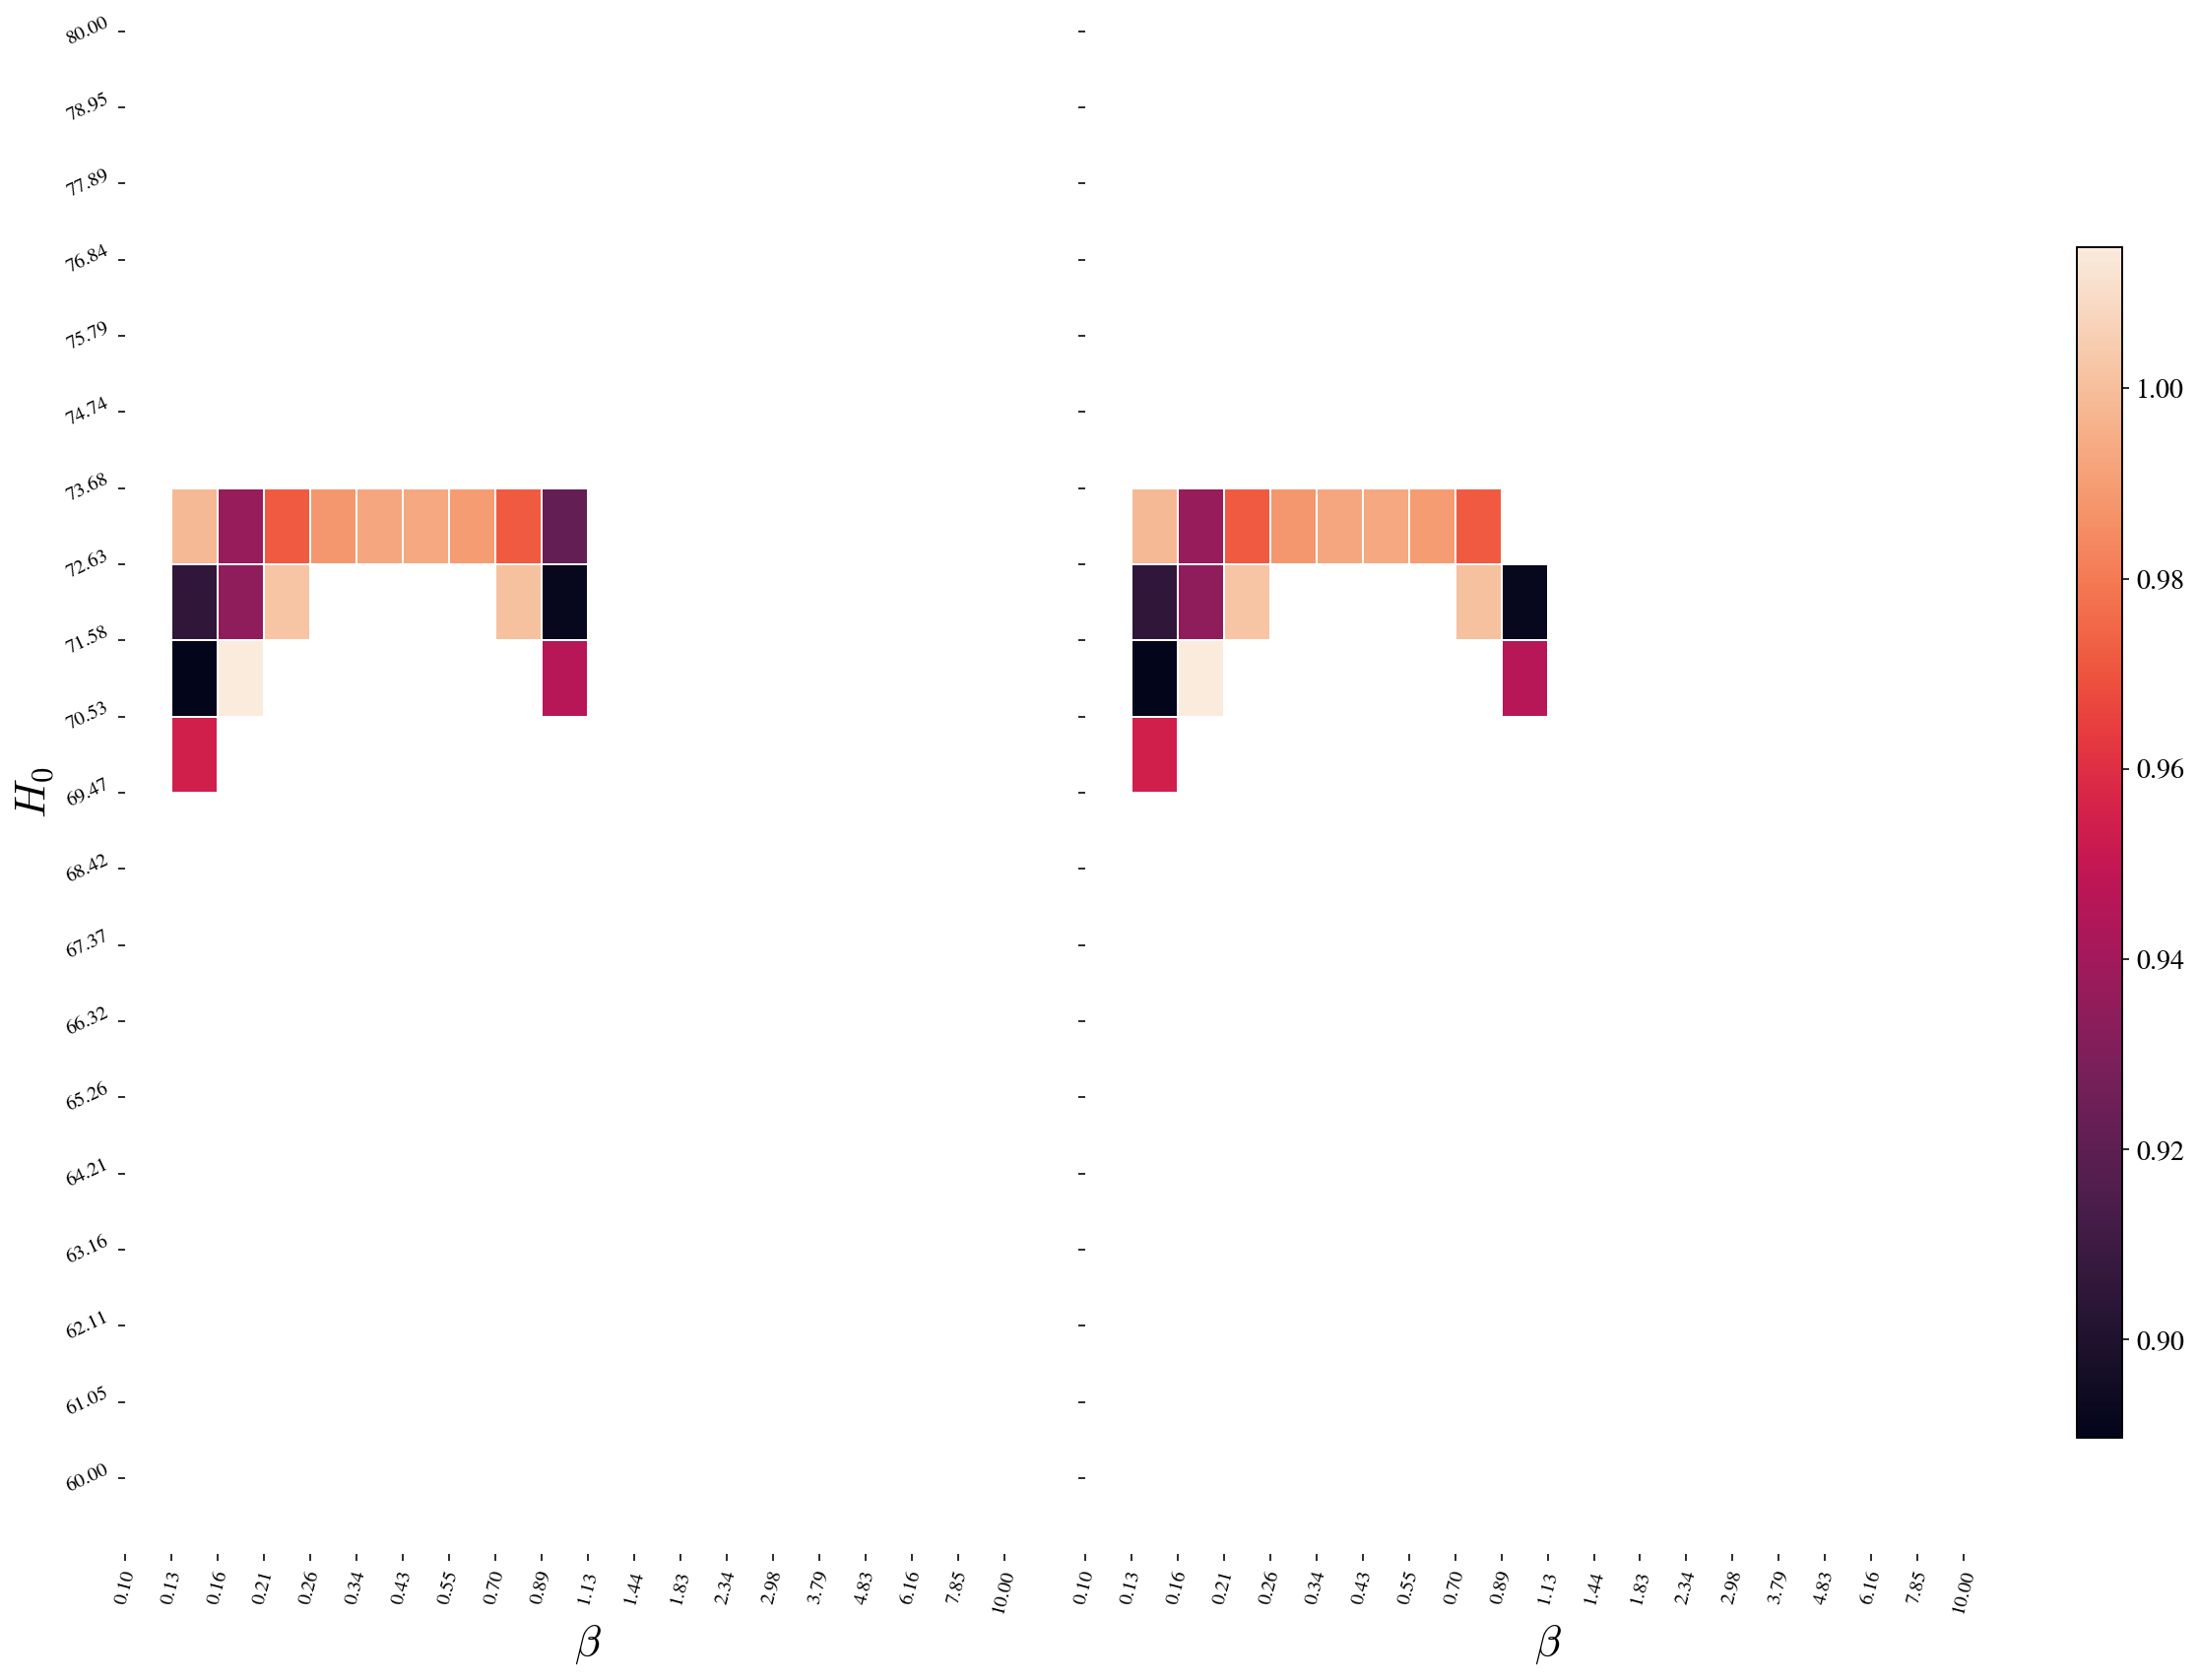

In [13]:
# Plot GILA model
fig, axes = plt.subplots(1,2,figsize=(16, 12))
# Define common color scale
vmin = min(np.nanmin(masked_data_with_1_sigma_2d), np.nanmin(masked_data_with_aou_1_sigma_2d))
vmax = max(np.nanmax(masked_data_with_1_sigma_2d), np.nanmax(masked_data_with_aou_1_sigma_2d))

# Plot heatmaps without colorbars
sns.heatmap(masked_data_with_1_sigma_2d, ax=axes[0], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(masked_data_with_aou_1_sigma_2d, ax=axes[1], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)

# General configurations for all axes
for ax in axes.flat:
    ax.set_xlabel(r'$\beta$', fontsize=22)
    ax.set_ylabel(r'$H_0$', fontsize=22)
    ax.set_xticks(np.arange(len(L_bar_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in L_bar_values],rotation = 75)
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values],rotation = 25)
    ax.label_outer()

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position as needed
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

# Change colorbar tick label size
cbar.ax.tick_params(labelsize=14)  # Set fontsize

fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


fig.savefig(os.path.join(path_figures, 'heat_map_aou_PG_r={0}_s={1}_beta=1.png'.format(r,s)))
fig.savefig(os.path.join(path_figures, 'heat_map_aou_PG_r={0}_s={1}_beta=1.pdf'.format(r,s)))
plt.show()



# Confidence intervals 

In [14]:
print('PG model')
print('Exponents: r = {0}, s = {1}'.format(r,s))
print(r'M abs: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,2]), np.std(samples[:,2])))
print(r'H0: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,0]), np.std(samples[:,0])))
print(r'$\L$: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,1]), np.std(samples[:,1])))


PG model
Exponents: r = 1, s = 3
M abs: -19.385026 \pm 0.235398
H0: 69.882758 \pm 5.977473
$\L$: 0.355455 \pm 0.234696
